# Setup

Today, we will implement transformers. It revolutionalize natural language processing task and open the door for large language model like chatGPT and other. 

The Transformers is an architecture provide by Google and outperformed previuous architecture like LSTM, RNN where we need to deal with a huge amount of data.

**Game of the work:** Implement a model capable to make discussion like the popular tv show **FRIENDS**

This is the link of the dataset [here](https://www.kaggle.com/datasets/cyygnusx1/talk-like-friends)

In [1]:
import math
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm  
from sklearn.manifold import TSNE
from transformers import BertTokenizer


# Code

In [2]:
dset = pd.read_excel("/Users/armandbryan/Documents/articles implementation/articles/transformers/FRIEND scripts datasets/final_raw_data.xlsx")
print(dset.columns)
print("*"*60)
print(dset.shape)
dset.head(3)

Index(['Season', 'Episode', 'Episode name', 'Directed by', 'Written by',
       'Revenue in millions(US)', 'Episode Rating(10)',
       'Rank(10) done by screenrant according to IMBD', 'Cast', 'Line'],
      dtype='object')
************************************************************
(49499, 10)


,Season,Episode,Episode name,Directed by,Written by,Revenue in millions(US),Episode Rating(10),Rank(10) done by screenrant according to IMBD,Cast,Line
0,1,1,"""The One Where Monica Gets a Roommate""",James Burrows,David Crane & Marta Kauffman,21.5,8.3,9,monica,there's nothing to tell! he's just some guy i...
1,1,1,"""The One Where Monica Gets a Roommate""",James Burrows,David Crane & Marta Kauffman,21.5,8.3,9,joey,"c'mon, you're going out with the guy! there's..."
2,1,1,"""The One Where Monica Gets a Roommate""",James Burrows,David Crane & Marta Kauffman,21.5,8.3,9,chandler,"all right joey, be nice. so does he have a h..."


In [3]:
# We don't have a lot of memory we will use only 50% of the dataset
size = int(len(dset) * 0.2)
dset = dset[:size]
print("New shape: {}".format(dset.shape))

New shape: (9899, 10)


## Preprocess

Okay we have correctly load the dataset. Now we need to prepare well the dataset before perform transformers on it. Let's divide the tasks to achieve this goal.
- Understand well the dataset
- Use only right columns of our dataset
- Perform features engineering if necessarily
- Cuz it's a text task we will tokenize it 
- Transform categorical values at numerical values (Embedding)

After perform all the tasks we will be ready to implement transformers from scratch.

`Note:` Task like tokenization and embedding will be explained after.

In [4]:
"""
Yeah after analyze the dataset, we can said that "line" will only be use in our model.
The output is the result of the model
"""
dset = dset["Line"]
print(dset.head())

0     there's nothing to tell! he's just some guy i...
1     c'mon, you're going out with the guy! there's...
2     all right joey, be nice.  so does he have a h...
3                             wait, does he eat chalk?
4     just, 'cause, i don't want her to go through ...
Name: Line, dtype: object


Imagine you're trying to teach a child to read. Instead of diving straight into complex paragraphs, you'd start by introducing them to individual letters, then syllables, and finally, whole words. In a similar vein, tokenization breaks down vast stretches of text into more digestible and understandable units for machines.

The primary goal of tokenization is to represent text in a manner that's meaningful for machines without losing its context. By converting text into tokens, algorithms can more easily identify patterns. This pattern recognition is crucial because it makes it possible for machines to understand and respond to human input. For instance, when a machine encounters the word "running", it doesn't see it as a singular entity but rather as a combination of tokens that it can analyze and derive meaning from.

To delve deeper into the mechanics, consider the sentence, "Chatbots are helpful." When we tokenize this sentence by words, it transforms into an array of individual words:

`["Chatbots", "are", "helpful"].`

In [5]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print(device)

mps


In [6]:
device = "cpu"

In [7]:
# Perform tokenization using Berttokenizer to go fast
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
list_dset = [str(x) for x in dset]
print(list_dset[:5])
tokens = tokenizer(list_dset, padding=True, truncation=True, return_tensors="pt").to(device)
print(tokens['input_ids'][:5])

[" there's nothing to tell! he's just some guy i work with!", " c'mon, you're going out with the guy! there's gotta be something wrong with him!", ' all right joey, be nice.  so does he have a hump? a hump and a hairpiece?', ' wait, does he eat chalk?', " just, 'cause, i don't want her to go through what i went through with carl- oh!"]

/opt/anaconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



tensor([[ 101, 2045, 1005,  ...,    0,    0,    0],
        [ 101, 1039, 1005,  ...,    0,    0,    0],
        [ 101, 2035, 2157,  ...,    0,    0,    0],
        [ 101, 3524, 1010,  ...,    0,    0,    0],
        [ 101, 2074, 1010,  ...,    0,    0,    0]])


In [8]:
input_ids = tokens['input_ids']
vocab_size = tokenizer.vocab_size
print("vocab_size = {}".format(vocab_size))
embedding_dim = 512
embedding_weights = torch.randn(vocab_size, embedding_dim, device = device)
print("Shape: {}".format(embedding_weights.shape))
embedded_inputs = embedding_weights[input_ids] 

vocab_size = 30522
Shape: torch.Size([30522, 512])


In [9]:
""" embeddings = embedded_inputs.view(-1, embedding_dim).cpu().detach().numpy()
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)
# Figure
plt.figure(figsize=(10, 10))
plt.style.use('dark_background')
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=1, alpha=0.7, color='white')
plt.xlabel('Dimension 1', color='white')
plt.ylabel('Dimension 2', color='white')
plt.title('Projection 2D des Embeddings', color='white')
plt.gca().spines['bottom'].set_color('white')
plt.gca().spines['left'].set_color('white')
plt.gca().tick_params(colors='white')
plt.show() """

" embeddings = embedded_inputs.view(-1, embedding_dim).cpu().detach().numpy()\ntsne = TSNE(n_components=2, random_state=42)\nembeddings_2d = tsne.fit_transform(embeddings)\n# Figure\nplt.figure(figsize=(10, 10))\nplt.style.use('dark_background')\nplt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=1, alpha=0.7, color='white')\nplt.xlabel('Dimension 1', color='white')\nplt.ylabel('Dimension 2', color='white')\nplt.title('Projection 2D des Embeddings', color='white')\nplt.gca().spines['bottom'].set_color('white')\nplt.gca().spines['left'].set_color('white')\nplt.gca().tick_params(colors='white')\nplt.show() "

In [10]:
batch_size, seq_length, embedding_dim = embedded_inputs.size()
print(batch_size)
print(seq_length)
print(embedding_dim)

9899
266
512


## Model

<img src = "architecture.png" width = 50%, height = 50%>

Transformers is an great architecture. It's composed of Encoder and Decoder. The particular of transformers it's the self attention mecanism who can help the model to concentrate on most important values of the dataset.

The steps to implement transformers from scratch are:
- Embedding
- Positional Embedding
- Attention mecanism
- Multi Head attention
- Feed Forward Network
- Layer Normalization
- Assembly and create Encoder layer
- Assembly Decoder layer


Let's start with $attention$

$$Attention(Q,K,V) = softmax(\frac{QK^T}{\sqrt{d_k}})V$$

Let's implement it in python 

In [11]:
def self_attention(embedding_inputs):
    """Self attention mechanism"""
    batch_size, seq_length, embedding_dim = embedding_inputs.size()
    
    # Initialize weight
    W_Q = torch.randn(embedding_dim, embedding_dim, device = device)
    W_K = torch.randn(embedding_dim, embedding_dim, device = device)
    W_V = torch.randn(embedding_dim, embedding_dim, device = device)
    
    # Calcul of Q, K, V
    Q = embedding_inputs @ W_Q  # [batch_size, seq_length, embedding_dim]
    K = embedding_inputs @ W_K  # [batch_size, seq_length, embedding_dim]
    V = embedding_inputs @ W_V  # [batch_size, seq_length, embedding_dim]
    
    # Calcul of attention socore
    scale = math.sqrt(embedding_dim)
    scores = (Q @ K.transpose(-2, -1)) / scale  # [batch_size, seq_length, seq_length]
    
    # Softmax application
    attention = torch.softmax(scores, dim=-1)
    
    # Output 
    attention_output = attention @ V  # [batch_size, seq_length, embedding_dim]
    return attention_output

By visualizing embeddings in 2D space, you gain valuable intuition about how the model processes and represents data, which is essential for developing high-performance and reliable models.

torch.Size([9899, 266, 512])
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9899 samples in 0.005s...
[t-SNE] Computed neighbors for 9899 samples in 0.962s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9899
[t-SNE] Computed conditional probabilities for sample 2000 / 9899
[t-SNE] Computed conditional probabilities for sample 3000 / 9899
[t-SNE] Computed conditional probabilities for sample 4000 / 9899
[t-SNE] Computed conditional probabilities for sample 5000 / 9899
[t-SNE] Computed conditional probabilities for sample 6000 / 9899
[t-SNE] Computed conditional probabilities for sample 7000 / 9899
[t-SNE] Computed conditional probabilities for sample 8000 / 9899
[t-SNE] Computed conditional probabilities for sample 9000 / 9899
[t-SNE] Computed conditional probabilities for sample 9899 / 9899
[t-SNE] Mean sigma: 2.718539
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.006889
[t-SNE] KL divergence after 1000 iterations: 1.356029


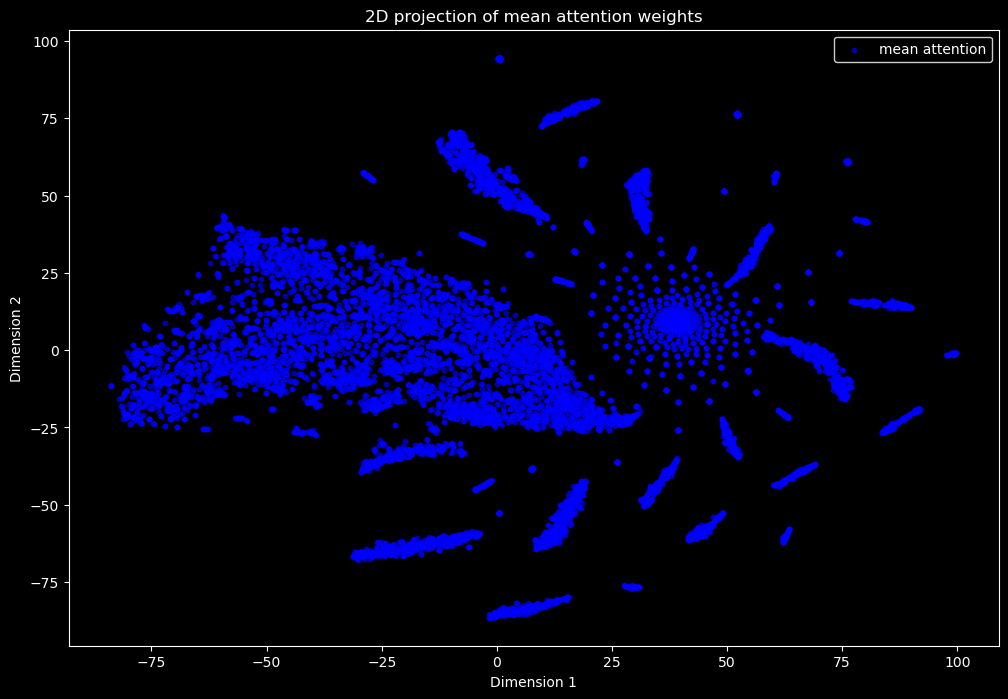

In [12]:
attention = self_attention(embedded_inputs)
print(attention.shape)


sequence_embeddings = attention.mean(dim=1)
embeddings_np = sequence_embeddings.cpu().detach().numpy()
tsne = TSNE(n_components=2, random_state=42, n_jobs=-1, verbose=1)
embeddings_2d = tsne.fit_transform(embeddings_np)

plt.figure(figsize=(12, 8), facecolor='black')
ax = plt.gca()
ax.set_facecolor('black')

plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
            s=10, alpha=0.6, color='blue', label='mean attention')

plt.xlabel('Dimension 1', color='white')
plt.ylabel('Dimension 2', color='white')
plt.title('2D projection of mean attention weights', color='white')

plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

for spine in ax.spines.values():
    spine.set_edgecolor('white')

legend = plt.legend(facecolor='black', edgecolor='white', labelcolor='white')
for text in legend.get_texts():
    text.set_color('white')

plt.show()

This visualization shows how a self-attention model learned to distribute its attention between different words or sub-parts of a given text. Dense clusters and connections between points can represent syntactic and semantic relationships learned by the model.

In Transformer models, positional encoding is a technique used to inject information about the position of each token in a sequence. Since Transformers rely entirely on self-attention mechanisms, which are position-invariant, they lack a built-in way to capture the sequential order of tokens. Positional encoding addresses this by adding positional information to the token embeddings.

Positional Encoding is important because:
- **Maintaining Sequence Order:** Natural language is sequential, and the meaning of a sentence often depends on the order of words. Without positional encoding, a Transformer would treat the sequence as a bag of words, losing essential context.
- **Distinguishing Token Positions:** It enables the model to differentiate tokens based on their positions, allowing it to learn positional relationships.
- **Learning Dependencies:** Positional encoding helps the model learn both short-term and long-term dependencies between tokens.

We will use sinus cosinus to perform positional encoding.

$$PE_(pos, 2i) = \sin({pos/10000^{2i/d_{model}}})$$
$$PE_(pos, 2i+1) = \cos({pos/10000^{2i/d_{model}}})$$

In [13]:
def positional_encoding(seq_length, embedding_dim):
    """Positional Encoding"""
    pos = torch.arange(0, seq_length, dtype = torch.float32, device = device).unsqueeze(1)
    term = torch.exp(torch.arange(0, embedding_dim, 2, dtype = torch.float, device = device) * -(math.log(10000.0)/ embedding_dim))
    pe = torch.zeros(seq_length, embedding_dim, device = device)
    pe[:, 0::2] = torch.sin(pos / term)
    pe[:, 1::2] = torch.cos(pos / term)
    pe = pe.unsqueeze(0)
    return pe 

In [14]:
pe = positional_encoding(seq_length, embedding_dim)
embedded_inputs = embedded_inputs + pe
attention = self_attention(embedded_inputs)

Multi-head attention is an extension of the self-attention mechanism used in Transformer architectures. Instead of performing a single attention function, the model computes multiple attention functions (called “*heads*”) in parallel. Each head operates on a different subspace of the embedding dimensions.

In [15]:
# Ajust self attention function
def self_attention(Q, K, V, scale):
    """Self-attention mechanism for multi-head attention"""
    scores = torch.matmul(Q, K.transpose(-2, -1)) / scale
    attention = torch.softmax(scores, dim=-1)
    attention_output = torch.matmul(attention, V)
    return attention_output

# Multi-head attention function
def multi_head_attention(embedding_inputs, num_heads = 4):
    batch_size, seq_length, embedding_dim = embedding_inputs.size()
    head_dim = embedding_dim // num_heads
    
    # Reshape embeddings
    embedding_inputs = embedding_inputs.view(batch_size, seq_length, num_heads, head_dim)
    embedding_inputs = embedding_inputs.permute(0, 2, 1, 3)
    
    # Initialize weights
    W_Q = torch.randn(num_heads, head_dim, head_dim, requires_grad = True, device = device)
    W_K = torch.randn(num_heads, head_dim, head_dim, requires_grad = True, device = device)
    W_V = torch.randn(num_heads, head_dim, head_dim, requires_grad = True, device = device)
    
    # Compute Q, K, V
    Q = torch.matmul(embedding_inputs, W_Q)
    K = torch.matmul(embedding_inputs, W_K)
    V = torch.matmul(embedding_inputs, W_V)
    
    # Scale factor
    scale = math.sqrt(head_dim)
    
    # Self-attention
    attention_output = self_attention(Q, K, V, scale)
    
    # Concatenate heads
    attention_output = attention_output.permute(0, 2, 1, 3).contiguous()
    attention_output = attention_output.view(batch_size, seq_length, embedding_dim)
    
    return attention_output

In [16]:
class ScriptDataset(torch.utils.data.Dataset):
    def __init__(self, input_ids):
        self.input_ids = input_ids
            
    def __len__(self):
        return self.input_ids.size(0)
        
    def __getitem__(self, idx):
        input_ids = self.input_ids[idx]
        if input_ids.size(0) < 2:
            input_ids = torch.tensor([tokenizer.pad_token_id, tokenizer.pad_token_id])
        return {
            'input_ids': input_ids[:-1],
            'labels': input_ids[1:]
        }

In [17]:
#device = "mps"
dataset = ScriptDataset(input_ids)

In [18]:
class TransformerLanguageModel(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim = 768, n_heads = 8, n_layers = 6, dropout = 0.6):
        super(TransformerLanguageModel, self).__init__()
        self.embedding_dim = embedding_dim
        self.token_embedding = torch.nn.Embedding(vocab_size, embedding_dim)
        self.position_embedding = torch.nn.Embedding(512, embedding_dim) 
        self.layers = torch.nn.ModuleList([
            torch.nn.TransformerDecoderLayer(d_model=embedding_dim, nhead=n_heads, dropout=dropout)
            for _ in range(n_layers)
        ])
        self.dropout = torch.nn.Dropout(dropout)
        self.fc_out = torch.nn.Linear(embedding_dim, vocab_size)
        
    def forward(self, input_ids):
        seq_length = input_ids.size(1)
        positions = torch.arange(0, seq_length, device = input_ids.device).unsqueeze(0)
        
        x = self.token_embedding(input_ids) + self.position_embedding(positions)
        x = self.dropout(x)
        
        # Create a causal mask to mask future tokens
        causal_mask = torch.triu(torch.ones(seq_length, seq_length, device = input_ids.device), diagonal = 1).bool()
        # Pass through the Transformer layers
        for layer in self.layers:
            x = layer(tgt = x.transpose(0, 1), memory=None, tgt_mask = causal_mask).transpose(0, 1)
        
        logits = self.fc_out(x)
        return logits

In [19]:
def collate_fn(batch):
    # Filter out None values
    batch = [b for b in batch if b is not None]
    return {
        'input_ids': torch.stack([b['input_ids'] for b in batch]),
        'labels': torch.stack([b['labels'] for b in batch])
    }

In [20]:
from torch.utils.data.dataloader import default_collate

def collate_fn(batch):
    batch = [b for b in batch if b is not None]
    return default_collate(batch) if batch else None

train_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)
train_loader = (batch for batch in train_loader if batch is not None)

In [21]:
vocab_size = tokenizer.vocab_size
model = TransformerLanguageModel(vocab_size).to(device)
print(model)

TransformerLanguageModel(
  (token_embedding): Embedding(30522, 768)
  (position_embedding): Embedding(512, 768)
  (layers): ModuleList(
    (0-5): 6 x TransformerDecoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
      )
      (multihead_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
      )
      (linear1): Linear(in_features=768, out_features=2048, bias=True)
      (dropout): Dropout(p=0.6, inplace=False)
      (linear2): Linear(in_features=2048, out_features=768, bias=True)
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm3): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.6, inplace=False)
      (dropout2): Dropout(p=0.6, inplace=False)
      (dropout3): Dropout(p=0.6, inp

In [22]:
criterion = torch.nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

: 

In [23]:
num_epochs = 5
train_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", colour='green')
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids)
        
        loss = criterion(outputs.view(-1, outputs.size(-1)), labels.view(-1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        progress_bar.set_postfix(loss = loss.item())
    
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)
    print(f"Epoch {epoch+1} Average Loss: {avg_epoch_loss:.4f}")

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_losses, marker='o', color='blue')
plt.title('Training Loss over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.grid(True)
plt.xticks(range(1, num_epochs+1))
plt.tight_layout()
plt.show()

Epoch 1/5: 0it [00:00, ?it/s]

In [ ]:
def generate_text(model, tokenizer, prompt, max_length=50, temperature=1.0):
    model.eval()
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
    generated = input_ids

    with torch.no_grad():
        for _ in range(max_length):
            outputs = model(generated)
            next_token_logits = outputs[:, -1, :] / temperature
            probabilities = torch.softmax(next_token_logits, dim=-1)
            next_token_id = torch.multinomial(probabilities, num_samples=1)
            generated = torch.cat([generated, next_token_id], dim=-1)
            
            if next_token_id.item() == tokenizer.sep_token_id:
                break

    output_text = tokenizer.decode(generated[0], skip_special_tokens=True)
    return output_text

def chat_with_model(model, tokenizer):
    print("Enter 'quit' to exit the chat.")
    while True:
        prompt = input("You: ")
        if prompt.lower() == 'quit':
            break
        response = generate_text(model, tokenizer, prompt)
        print(f"Model: {response}")

In [ ]:
# Start chatting
chat_with_model(model, tokenizer)